In [30]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from collections import OrderedDict
import os
import subprocess
%matplotlib inline
plt.style.use('ggplot')

mpl.rcParams['font.size'] = 14
mpl.rcParams['ytick.right'] = False
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6


In [31]:
TIMING_BASELINES_DIR = "./baselines"

Define the functions for which we want to see the timing in the bar chart

In [32]:
#***********************************************************
# Marco: Not sure whether we need this block within #*****
# res = {
#     "sample::1st_shift":"1st shift",
#     "sample::FFT":"FFT",
#     "sample::2nd_shift":"2nd shift",
#     "sample::interpolate":"interpolate",
#     "sample::apply_phase_sampled":"apply phase",
# }
# funcs_gpu = {
#     "chi2_profile::malloc_fint":"malloc fint",
#     "chi2_profile::copy_observations":"copy observations",
#     # "copy_input_H->D":"copy input H->D",
#     "create_image:": "create image",
#     "sample::copy_uv_H->D":"uv H->D",
#     "sample::copy_uvrot_D->D":"uvrot D->D",
#     "sample::1st_shift":"1st shift",
#     "sample::FFT":"FFT",
#     "sample::2nd_shift":"2nd shift",
#     "sample::interpolate":"interpolate",
#     "sample::apply_phase_sampled":"apply phase",
#     "reduce_chi2::diff_weighted":"weighted diff.",
#     "reduce_chi2::reduction":"reduction",
#     # "reduce_chi2":"reduce_chi2",
#     #"chi2_image::free_all":"chi2_image::free_all",
# }
# funcs_cpu = {
#     "chi2_profile::malloc_fint" : "malloc fint",
#     "create_image:" :"create image",
#     "reduce_chi2::diff_weighted":"weighted diff.",
#     "reduce_chi2::reduction":"reduction",
#     # "chi2_profile::free_fint" : "free fint",
# }
#***********************************************************

def funcs(gpu=True, input_type="profile"):
    profile = input_type == "profile"
    res = OrderedDict()
    # res is an OrderedDict, thus the order the entries are created matters. 
    # The order in res is the same as it is plotted.
    
    if gpu:
        if profile:
#             res["chi2_profile::malloc_fint:"] = "malloc fint" # do not show
            res["chi2_profile::copy_observations:"] = r"Copy $V_{\mathrm{obs}}(u_k, v_k)$"
        else:
#             res["chi2_image::malloc_fint:"] = "malloc fint" # do not show
            res["chi2_image::copy_observations:"] = r"Copy $V_{\mathrm{obs}}(u_k, v_k)$"
        res["sample::copy_uv_H->D:"] = r"Copy $(u_k, v_k)$"
#         res["sample::copy_uvrot_D->D:"] = "uvrot D->D" # do not show

        if profile:
            res["create_image:"] = r"Create Image $I(x,y)$"
        else:
            res["copy_input_H->D:"] = r"Copy Image $I(x,y)$"
        
        res["sample::uv_rotate"] = r"Rotate $(u_k, v_k)$"



    else: # CPU
        if profile:
#             res["chi2_profile::malloc_fint:"] = "malloc fint" # do not show
            res["create_image:"] = r"Create Image $I(x,y)$"
        else:
            res["chi2_imag::fftw_alloc:"] = "malloc image"
            res["sample_image::copy_input:"] = r"Copy Image $I(x,y)$"
        
        res["uv_rotate_h"] = r"Rotate $(u_k, v_k)$"


    # the last functions are the same in all cases
    res["sample::1st_shift:"] = "1st FFTshift"
    res["sample::FFT:"] = "FFT"
    res["sample::2nd_shift:"] = "2nd FFTshift"
    res["sample::interpolate:"] = r"Sample $V_{\mathrm{mod}}$"
    res["sample::apply_phase_sampled:"] = r"Translate $V_{\mathrm{mod}}(u_k, v_k)$"
    res["reduce_chi2::diff_weighted:"] = r"Compute $\chi^2_k$"
    res["reduce_chi2::reduction:"] = "Reduce"
    
    return res    

In [33]:
# set of unique labels
#list(set(funcs_gpu.values()).union(funcs_cpu.values()))

In [35]:
cmap = get_cmap('tab20c')
colors = OrderedDict()

# colors["malloc fint"] = cmap(0.1)
colors[r"Copy $V_{\mathrm{obs}}(u_k, v_k)$"] = cmap(2)
colors["Copy $(u_k, v_k)$"] = cmap(1)
colors[r"Copy Image $I(x,y)$"] = cmap(0)
colors[r"Create Image $I(x,y)$"] = cmap(12)
# colors["uvrot D->D"] = cmap(0.7)
colors["Rotate $(u_k, v_k)$"] = '#fbe400' #cmap(16)
colors["1st FFTshift"] = cmap(10)
colors["FFT"] = cmap(8)
colors["2nd FFTshift"] = cmap(10)
colors[r"Sample $V_{\mathrm{mod}}$"] = cmap(7)
colors[r"Translate $V_{\mathrm{mod}}(u_k, v_k)$"] = cmap(6)
colors[r"Compute $\chi^2_k$"] = cmap(5)
colors["Reduce"] = cmap(4)
#colors["free fint"] = cmap(0.55)

20


Learn how many lines of timing output are between two summary lines with 

    grep -n float64 logfile
    
This number is different for CPU and GPU. Extracting it from the command line using 

    $ grep -n float64 baseline_e42f83a_datalab-c-ru72xaf.log | grep -B1 '16384.*float64[[:space:]]0[[:space:]]256' | grep -o ^.*\: | rev | cut -c 2- | rev
    14002
    14254
    
Explaination: first find lines with float64 and number them, then select only the one we want and the line before, then extract the line numbers


In [36]:
subprocess.check_output("grep -n float64 baseline_e42f83a_datalab-c-ru72xaf.log | grep -B1 '16384.*float64[[:space:]]0[[:space:]]256' | grep -o ^.*\: | rev | cut -c 2- | rev", shell=True)

b''

In [37]:
def read_results(logfile, func, size=4096, 
                 tpb=0, ompnthreads=0,
                 outfile="/tmp/out.csv"):
    assert((tpb > 0) ^ (ompnthreads > 0))
    
    # determine how many timing output lines a la
    # [GPU] chi2_image::*
    # are between two summary lines. 
    # Assume that 1,2 openMP threads and 16, 32 tpb are always
    # checked for a 4k image
    cmd = "grep -n float64 {} | grep -B1 '4096.*float64[[:space:]]{}[[:space:]]{}' | grep -o ^.*\: | rev | cut -c 2- | rev > {}"
    
    if tpb > 0:
        cmd = cmd.format(logfile, 0, 32, outfile) 
        tag = "[GPU]"
    else:
        cmd = cmd.format(logfile, 2, 0, outfile) 
        tag = "[CPU]"
    subprocess.check_call(cmd, shell=True)
    line_numbers = np.loadtxt(outfile, usecols=0)
    nlines = int(line_numbers[1] - line_numbers[0])
    assert(nlines > 1)
    
    # now grep the actual results
    cmd = "grep -E -B{0} '{1}.*float64\t{2}\t{3}' {4} | grep -F '{5} {6}' > {7}".format(
            nlines, size, ompnthreads, tpb, logfile, tag, func, outfile)
    #print(cmd)
    subprocess.check_call(cmd, shell=True)
    return np.loadtxt(outfile, usecols=2)
    

# read_results(logfile, "sample::FFT", tpb=32)

In [38]:
def aggregate_results(logfile, size=4096, 
                      tpb = 32, ompnthreads=12,
                      input_type="profile"):
    # print("minimum time over all cycles for size={}, tpb={}, nthreads={}".format(size, tpb, ompnthreads))
    timings_gpu = []
    timings_cpu = []
    for k,v in funcs(True, input_type).items():
        timings_gpu.append(np.min(read_results(logfile, k, tpb=tpb)))
        # print(v, timings_gpu[-1], "ms, ", timings_cpu[-1], "ms")
    for k,v in funcs(False, input_type).items():
        timings_cpu.append(np.min(read_results(logfile, k, ompnthreads=ompnthreads)))
    return timings_gpu, timings_cpu

# timings_gpu, timings_cpu = aggregate_results(logfile)

Plot a bar chart

In [85]:
def plot_bars(timings_gpu, timings_cpu, input_type="profile", verbose=True):
    N = 2 # number of bars
    ind = np.array([0, 4, 8])-1   # the x locations for the groups
    width = 2.5       # the width of the bars

    fig = plt.figure(figsize=(6,6))

    # accumulate patches with right color just for the legend
    # but don't show them. Assume that there is no function for CPU
    # that doesn't exist for the GPU
    patches = []
    labels = []
    for k, v in funcs(True, input_type).items():
        patches.append(plt.bar([0], [1], color=colors[v]))
        labels.append(v)
    plt.clf()
    
    def plot_bar(timings, gpu=True):
        n = 1 if gpu else 2
        last = 0
        for i, (k, v) in enumerate(funcs(gpu, input_type).items()):
            t = timings[i]
            if verbose: print("label:", v, ", t=", t)
            patches.append(plt.bar([ind[n]], [t], width, color=colors.get(v, (0, 0, 0, 1)), bottom=[last])[0])
            last += t
            
    print("GPU"); plot_bar(timings_gpu, True)
    print("CPU"); plot_bar(timings_cpu, False)

    # plt.xticks(None)
    plt.ylabel('time (ms)')
    plt.title('chi2{}()'.format(input_type.title()))
    plt.xlim(0, 25)
    plt.ylim(0, 100)

    ax = plt.gca()
    ax.set_xticks(ind[1:])
    ax.set_xticklabels(("GPU", "CPU") )
    plt.legend(patches, labels, loc='right', fontsize=14, frameon=False,)
    
    return fig


In [86]:
def barchart(logfile, size=4096, tpb=32, ompnthreads=12):
    # determine input type from label in file
    # success returns 0, so negate
    if not subprocess.call('grep -F chi2_image:: {}'.format(logfile), shell=True):
        input_type = "image"
    else:
        input_type = "profile"
    timings_gpu, timings_cpu = aggregate_results(logfile, size, tpb, ompnthreads, input_type)
    return plot_bars(timings_gpu, timings_cpu, input_type)
    

GPU
label: Copy $V_{\mathrm{obs}}(u_k, v_k)$ , t= 4.4431
label: Copy $(u_k, v_k)$ , t= 3.17805
label: Create Image $I(x,y)$ , t= 3.03078
label: Rotate $(u_k, v_k)$ , t= 0.21504
label: 1st FFTshift , t= 4.48512
label: FFT , t= 16.3161
label: 2nd FFTshift , t= 4.04746
label: Sample $V_{\mathrm{mod}}$ , t= 2.1841
label: Translate $V_{\mathrm{mod}}(u_k, v_k)$ , t= 0.611328
label: Compute $\chi^2_k$ , t= 0.366592
label: Reduce , t= 0.236832
CPU
label: Create Image $I(x,y)$ , t= 19.7758
label: Rotate $(u_k, v_k)$ , t= 1.12572
label: 1st FFTshift , t= 5.19037
label: FFT , t= 49.6531
label: 2nd FFTshift , t= 5.21203
label: Sample $V_{\mathrm{mod}}$ , t= 8.14588
label: Translate $V_{\mathrm{mod}}(u_k, v_k)$ , t= 4.13699
label: Compute $\chi^2_k$ , t= 1.21836
label: Reduce , t= 0.44768


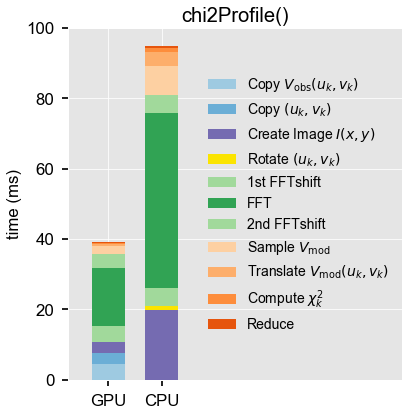

In [87]:
matrix_size = 4096

for n in [12]:
    chart = barchart(os.path.join(TIMING_BASELINES_DIR, "profile_profiling_baseline_af77476_calx174.ast.cam.ac.uk.txt"), 
             size=matrix_size, tpb=32, ompnthreads=n)
    
    chart.tight_layout()
    chart.savefig("profile_profiling_OMP{}_size{}.pdf".format(n, matrix_size))

GPU
label: Copy $V_{\mathrm{obs}}(u_k, v_k)$ , t= 4.43091
label: Copy $(u_k, v_k)$ , t= 3.30189
label: Copy Image $I(x,y)$ , t= 22.5151
label: Rotate $(u_k, v_k)$ , t= 0.22192
label: 1st FFTshift , t= 4.50349
label: FFT , t= 16.3154
label: 2nd FFTshift , t= 4.04992
label: Sample $V_{\mathrm{mod}}$ , t= 2.1848
label: Translate $V_{\mathrm{mod}}(u_k, v_k)$ , t= 0.571008
label: Compute $\chi^2_k$ , t= 0.366592
label: Reduce , t= 0.239872
CPU
label: malloc image , t= 0.001477
label: Copy Image $I(x,y)$ , t= 10.0909
label: Rotate $(u_k, v_k)$ , t= 1.12083
label: 1st FFTshift , t= 5.1429
label: FFT , t= 52.587
label: 2nd FFTshift , t= 5.14402
label: Sample $V_{\mathrm{mod}}$ , t= 8.20685
label: Translate $V_{\mathrm{mod}}(u_k, v_k)$ , t= 4.39709
label: Compute $\chi^2_k$ , t= 1.2187
label: Reduce , t= 0.461374


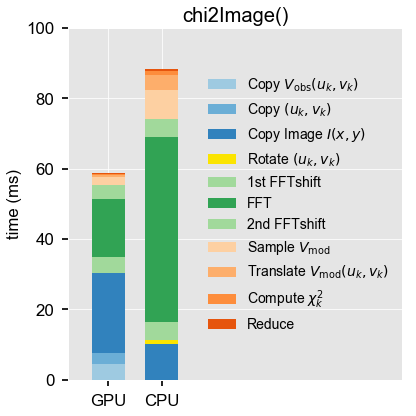

In [88]:
matrix_size = 4096

for n in [12]:
    chart = barchart(os.path.join(TIMING_BASELINES_DIR, "image_profiling_baseline_af77476_calx174.ast.cam.ac.uk.txt"), 
             size=matrix_size, tpb=32, ompnthreads=n)
    
    chart.tight_layout()
    chart.savefig("image_profiling_OMP{}_size{}.pdf".format(n, matrix_size))